<a href="https://colab.research.google.com/github/rrunix/AntecedentesAI/blob/master/Car_RL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrenamiento de Agentes con Deep Q-Network (DQN) en CarRacing-v3**

---

## **Descripcion**

En este notebook aprenderemos a entrenar agentes de **Aprendizaje por Refuerzo (Reinforcement Learning)** utilizando el algoritmo **DQN** en el entorno **CarRacing-v3** de Gymnasium. Este entorno simula una carrera de coches donde un agente debe aprender a conducir por un circuito generado proceduralmente.

### **Que es CarRacing-v3?**

CarRacing-v3 es un entorno clasico de Gymnasium para aprendizaje por refuerzo. Caracteristicas principales:

- **Observaciones**: Imagenes RGB de 96x96 pixeles
- **Acciones**: En modo discreto, 5 acciones posibles (nada, izquierda, derecha, acelerar, frenar)
- **Recompensas**: +1000/N por cada baldosa visitada, -0.1 por cada frame
- **Objetivo**: Completar el circuito en el menor tiempo posible

### **Libreria utilizada: Stable-Baselines3**

Utilizaremos **Stable-Baselines3**, una libreria de RL que proporciona implementaciones fiables y faciles de usar de algoritmos populares como PPO, A2C, SAC, DQN, etc.

### **Algoritmo: DQN (Deep Q-Network)**

DQN es un algoritmo clasico de deep reinforcement learning que combina Q-Learning con redes neuronales profundas. Sus ventajas incluyen:
- Excelente para espacios de accion discretos
- Estabilidad gracias al uso de experience replay
- Buen rendimiento con observaciones de imagenes

---

## **1. Instalacion de Dependencias**

Ejecuta las siguientes celdas para instalar todas las librerias necesarias. Esto incluye:
- **Stable-Baselines3**: Libreria de algoritmos de RL
- **Gymnasium**: Entornos de simulacion (incluye CarRacing-v3)
- **Dependencias de visualizacion**: Para renderizar el entorno en Colab

In [ ]:
# Instalacion de dependencias del sistema para renderizado en Colab
# swig es necesario para compilar box2d-py
!apt-get update -qq
!apt-get install -qq -y xvfb python-opengl ffmpeg swig build-essential > /dev/null 2>&1
print("Dependencias del sistema instaladas")

In [ ]:
# Instalacion de librerias de Python
!pip install -q swig
!pip install -q "gymnasium[box2d]"
!pip install -q "stable-baselines3[extra]"
!pip install -q sb3-contrib
!pip install -q pyvirtualdisplay
!pip install -q imageio imageio-ffmpeg
!pip install -q rl_zoo3

print("Librerias de Python instaladas")

---

## **2. Imports y Configuracion Inicial**

In [1]:
# Imports principales
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from PIL import Image
import imageio
import os

# Stable-Baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.monitor import Monitor

# Configuracion para visualizacion en Colab (solo si estamos en Colab)
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
    print("Ejecutando en Google Colab - Display virtual iniciado")
else:
    print("Ejecutando en entorno local")

print("Todas las librerias cargadas correctamente")

Ejecutando en entorno local
Todas las librerias cargadas correctamente


---

## **3. Exploracion del Entorno**

Antes de entrenar, vamos a explorar las caracteristicas del entorno CarRacing-v3 en modo discreto.

In [2]:
# Crear el entorno en modo discreto
env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)

print("=" * 50)
print("INFORMACION DEL ENTORNO")
print("=" * 50)
print(f"Espacio de observacion: {env.observation_space}")
print(f"Espacio de acciones: {env.action_space}")
print(f"\nForma de observacion: {env.observation_space.shape}")
print(f"Numero de acciones discretas: {env.action_space.n}")
print("\nAcciones disponibles:")
print("  - 0: No hacer nada")
print("  - 1: Girar a la izquierda")
print("  - 2: Girar a la derecha")
print("  - 3: Acelerar")
print("  - 4: Frenar")

INFORMACION DEL ENTORNO
Espacio de observacion: Box(0, 255, (96, 96, 3), uint8)
Espacio de acciones: Discrete(5)

Forma de observacion: (96, 96, 3)
Numero de acciones discretas: 5

Acciones disponibles:
  - 0: No hacer nada
  - 1: Girar a la izquierda
  - 2: Girar a la derecha
  - 3: Acelerar
  - 4: Frenar


/Users/rubenrodriguez/Documents/Workspace/antecedentes/AntecedentesAI/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


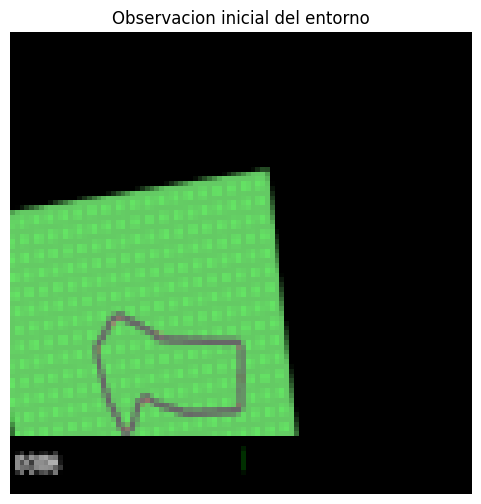

Forma de la observacion: (96, 96, 3)
Tipo de datos: uint8
Rango de valores: [0, 228]


In [3]:
# Visualizar una observacion inicial del entorno
obs, info = env.reset()

plt.figure(figsize=(6, 6))
plt.imshow(obs)
plt.title("Observacion inicial del entorno")
plt.axis('off')
plt.show()

print(f"Forma de la observacion: {obs.shape}")
print(f"Tipo de datos: {obs.dtype}")
print(f"Rango de valores: [{obs.min()}, {obs.max()}]")

env.close()

Recompensa total con acciones aleatorias: 1.36


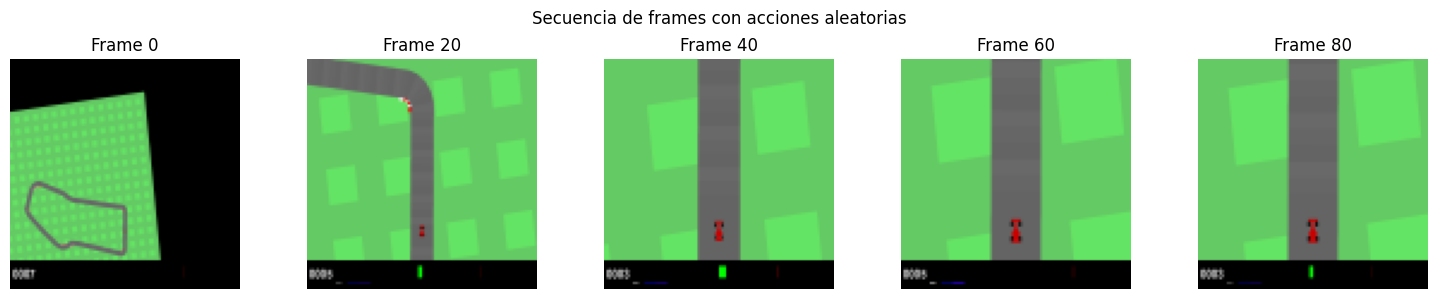

In [4]:
# Ejecutar algunas acciones aleatorias para ver como funciona
env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)
obs, info = env.reset()

frames = []
total_reward = 0

for step in range(100):
    # Accion aleatoria
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if step % 20 == 0:
        frames.append(obs)
    
    if terminated or truncated:
        break

print(f"Recompensa total con acciones aleatorias: {total_reward:.2f}")

# Mostrar algunos frames
fig, axes = plt.subplots(1, len(frames), figsize=(15, 3))
for i, (ax, frame) in enumerate(zip(axes, frames)):
    ax.imshow(frame)
    ax.set_title(f"Frame {i*20}")
    ax.axis('off')
plt.suptitle("Secuencia de frames con acciones aleatorias")
plt.tight_layout()
plt.show()

env.close()

---

## **4. Preparacion del Entorno para Entrenamiento**

Para entrenar con Stable-Baselines3, necesitamos preparar el entorno correctamente. Usaremos:
- **WarpFrame**: Convierte imagenes a escala de grises de 84x84 (reduccion de dimensionalidad)
- **VecFrameStack**: Apila varios frames consecutivos para dar contexto temporal al agente
- **VecTransposeImage**: Transpone las imagenes al formato esperado por PyTorch (canales primero)

In [5]:
# Configuracion del entorno
ENV_STR = "CarRacing-v3"
ENV_KWARGS = {"continuous": False}
GRAY_SCALE = True
N_ENVS = 1  # Numero de entornos paralelos
N_STACK = 4  # Numero de frames apilados

# Wrapper para convertir a escala de grises si se especifica
wrapper_class = WarpFrame if GRAY_SCALE else None

# Crear entorno de entrenamiento
env = make_vec_env(
    ENV_STR,
    n_envs=N_ENVS,
    env_kwargs=ENV_KWARGS,
    wrapper_class=wrapper_class
)
env = VecFrameStack(env, n_stack=N_STACK)
env = VecTransposeImage(env)

# Crear entorno de evaluacion
env_val = make_vec_env(
    ENV_STR,
    n_envs=N_ENVS,
    env_kwargs=ENV_KWARGS,
    wrapper_class=wrapper_class
)
env_val = VecFrameStack(env_val, n_stack=N_STACK)
env_val = VecTransposeImage(env_val)

print(f"Entorno preparado para entrenamiento")
print(f"Numero de entornos paralelos: {N_ENVS}")
print(f"Frames apilados: {N_STACK}")
print(f"Escala de grises: {GRAY_SCALE}")
print(f"Forma de observacion: {env.observation_space.shape}")

Entorno preparado para entrenamiento
Numero de entornos paralelos: 1
Frames apilados: 4
Escala de grises: True
Forma de observacion: (4, 84, 84)


---

## **5. Configuracion del Modelo DQN**

Ahora configuraremos el modelo DQN con una politica basada en redes neuronales convolucionales (CNN) para procesar las imagenes.

### **Hiperparametros importantes:**
- **buffer_size**: Tamano del replay buffer (memoria de experiencias)
- **learning_rate**: Tasa de aprendizaje
- **gamma**: Factor de descuento para recompensas futuras
- **exploration**: Control de la exploracion epsilon-greedy

In [6]:
# Detectar el mejor dispositivo disponible
import torch

if torch.cuda.is_available():
    device = "cuda"
    print("Usando GPU CUDA")
else:
    device = "cpu"
    print("Usando CPU")

# Configuracion de directorios
RL_TYPE = "DQN"
LOG_DIR = f"./logs/{ENV_STR}/{RL_TYPE}"
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.join(LOG_DIR, "checkpoint"), exist_ok=True)

# Configuracion del modelo DQN
model = DQN(
    'CnnPolicy',
    env,
    buffer_size=150_000,
    learning_rate=1e-4,
    gamma=0.99,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=1000,
    tensorboard_log=os.path.join(LOG_DIR, "tensorboard"),
    device=device,
    verbose=1
)

print("\n" + "=" * 50)
print("MODELO DQN CONFIGURADO")
print("=" * 50)
print(f"Politica: CnnPolicy")
print(f"Dispositivo: {device}")
print(f"Buffer Size: 150,000")
print(f"Learning Rate: 1e-4")
print(f"Directorio de logs: {LOG_DIR}")

Usando CPU
Using cpu device


/Users/rubenrodriguez/Documents/Workspace/antecedentes/AntecedentesAI/.venv/lib/python3.13/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.47GB > 4.10GB
  warnings.warn(



MODELO DQN CONFIGURADO
Politica: CnnPolicy
Dispositivo: cpu
Buffer Size: 150,000
Learning Rate: 1e-4
Directorio de logs: ./logs/CarRacing-v3/DQN


In [7]:
# Configurar callbacks para evaluacion y checkpoints
EVAL_FREQ = 25_000  # Evaluar cada 25k pasos

# Callback de evaluacion
eval_callback = EvalCallback(
    env_val,
    best_model_save_path=LOG_DIR,
    log_path=LOG_DIR,
    eval_freq=EVAL_FREQ,
    render=False,
    deterministic=True,
    n_eval_episodes=20
)

# Callback de checkpoints
checkpoint_callback = CheckpointCallback(
    save_freq=EVAL_FREQ,
    save_path=os.path.join(LOG_DIR, "checkpoint"),
    name_prefix="dqn_carracing"
)

# Lista de callbacks
callback_list = CallbackList([checkpoint_callback, eval_callback])

print("Callbacks configurados")
print(f"Evaluacion cada {EVAL_FREQ:,} pasos")
print(f"Checkpoints guardados en: {os.path.join(LOG_DIR, 'checkpoint')}")

Callbacks configurados
Evaluacion cada 25,000 pasos
Checkpoints guardados en: ./logs/CarRacing-v3/DQN/checkpoint


---

## **6. Entrenamiento**

**Nota importante**: CarRacing es un entorno complejo que requiere muchos pasos para aprender. 

| Timesteps | Tiempo aprox. (GPU) | Calidad esperada |
|-----------|---------------------|------------------|
| 100,000 | ~30-45 min | El coche empieza a moverse |
| 500,000 | ~2-3 horas | Conduce pero con errores |
| 1,000,000 | ~4-5 horas | Resultados decentes |
| 2,000,000+ | ~8+ horas | Buenos resultados |

> **Tip**: DQN puede requerir mas tiempo que PPO para converger en este entorno.

In [8]:
# ENTRENAMIENTO
# Ajusta total_timesteps segun el tiempo disponible
TOTAL_TIMESTEPS = 10

print(f"Iniciando entrenamiento por {TOTAL_TIMESTEPS:,} pasos...")
print(f"Con {N_ENVS} entorno(s) en {device}")
print(f"Algoritmo: DQN con CnnPolicy")

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=callback_list,
    progress_bar=True
)

print("\nEntrenamiento completado")

Iniciando entrenamiento por 10 pasos...
Con 1 entorno(s) en cpu
Algoritmo: DQN con CnnPolicy
Logging to ./logs/CarRacing-v3/DQN/tensorboard/DQN_1


Output()


Entrenamiento completado


In [9]:
# Guardar el modelo final
final_model_path = os.path.join(LOG_DIR, "final_model")
model.save(final_model_path)
print(f"Modelo final guardado en: {final_model_path}.zip")

# Evaluar el modelo final
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Modelo Final - Recompensa promedio: {mean_reward:.2f} +/- {std_reward:.2f}")

Modelo final guardado en: ./logs/CarRacing-v3/DQN/final_model.zip
Modelo Final - Recompensa promedio: -93.20 +/- 0.57


---

## **7. Evaluacion del Modelo Entrenado**

Vamos a evaluar el rendimiento del mejor modelo y visualizar su comportamiento.

In [13]:
# Cargar el mejor modelo
best_model_path = os.path.join(LOG_DIR, "final_model")
best_model = DQN.load(best_model_path)

# Crear entorno de evaluacion
eval_env = make_vec_env(
    ENV_STR,
    n_envs=1,
    seed=0,
    env_kwargs=ENV_KWARGS,
    wrapper_class=wrapper_class
)
eval_env = VecFrameStack(eval_env, n_stack=N_STACK)
eval_env = VecTransposeImage(eval_env)

# Evaluar
mean_reward, std_reward = evaluate_policy(best_model, eval_env, n_eval_episodes=20)
print(f"Mejor Modelo - Recompensa promedio: {mean_reward:.2f} +/- {std_reward:.2f}")

/Users/rubenrodriguez/Documents/Workspace/antecedentes/AntecedentesAI/.venv/lib/python3.13/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.47GB > 4.58GB
  warnings.warn(


Mejor Modelo - Recompensa promedio: -93.17 +/- 0.44


In [14]:
# Evaluar manualmente para obtener mas detalles
def evaluate_agent(model, n_episodes=5):
    """Evalua el agente y retorna estadisticas."""
    # Crear entorno de evaluacion
    eval_env = make_vec_env(
        ENV_STR,
        n_envs=1,
        env_kwargs=ENV_KWARGS,
        wrapper_class=wrapper_class
    )
    eval_env = VecFrameStack(eval_env, n_stack=N_STACK)
    eval_env = VecTransposeImage(eval_env)
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(n_episodes):
        obs = eval_env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            total_reward += reward[0]
            steps += 1
            
            if steps > 1000:  # Limite de pasos por episodio
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Episodio {episode + 1}: Recompensa = {total_reward:.2f}, Pasos = {steps}")
    
    eval_env.close()
    
    print("\n" + "=" * 50)
    print("RESULTADOS DE EVALUACION")
    print("=" * 50)
    print(f"Recompensa promedio: {np.mean(episode_rewards):.2f} +/- {np.std(episode_rewards):.2f}")
    print(f"Longitud promedio: {np.mean(episode_lengths):.0f} pasos")
    
    return episode_rewards, episode_lengths

# Evaluar el mejor modelo
rewards, lengths = evaluate_agent(best_model, n_episodes=5)

Episodio 1: Recompensa = -92.48, Pasos = 1000
Episodio 2: Recompensa = -93.35, Pasos = 1000
Episodio 3: Recompensa = -92.34, Pasos = 1000
Episodio 4: Recompensa = -93.55, Pasos = 1000
Episodio 5: Recompensa = -93.10, Pasos = 1000

RESULTADOS DE EVALUACION
Recompensa promedio: -92.96 +/- 0.48
Longitud promedio: 1000 pasos


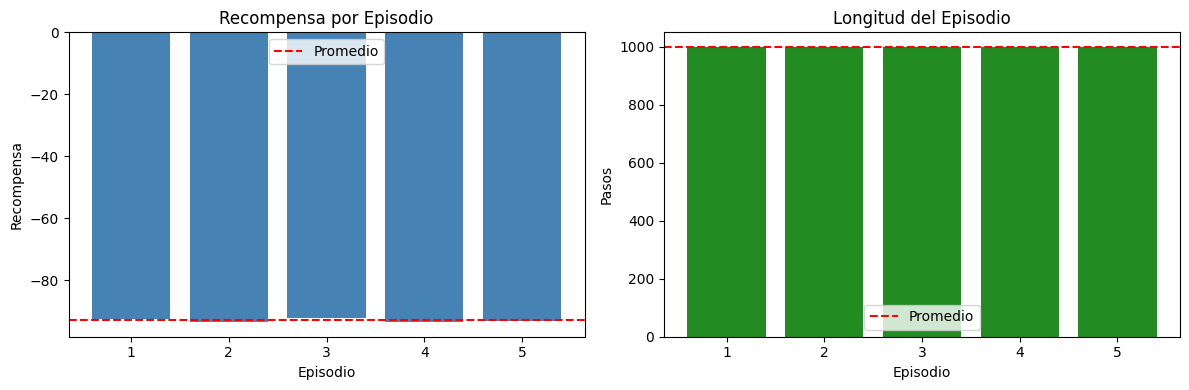

In [15]:
# Visualizar resultados de evaluacion
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, len(rewards) + 1), rewards, color='steelblue')
axes[0].axhline(y=np.mean(rewards), color='red', linestyle='--', label='Promedio')
axes[0].set_xlabel('Episodio')
axes[0].set_ylabel('Recompensa')
axes[0].set_title('Recompensa por Episodio')
axes[0].legend()

axes[1].bar(range(1, len(lengths) + 1), lengths, color='forestgreen')
axes[1].axhline(y=np.mean(lengths), color='red', linestyle='--', label='Promedio')
axes[1].set_xlabel('Episodio')
axes[1].set_ylabel('Pasos')
axes[1].set_title('Longitud del Episodio')
axes[1].legend()

plt.tight_layout()
plt.show()

---

## **8. Grabacion de Video**

Vamos a grabar un video del agente jugando para visualizar su comportamiento.

In [17]:
# Grabar un video del agente
def record_video(model, video_path="agent_video.mp4", max_steps=1000):
    """Graba un video del agente jugando."""
    # Crear entorno para grabacion (sin wrappers de procesamiento)
    raw_env = gym.make(ENV_STR, render_mode="rgb_array", **ENV_KWARGS)
    
    # Crear entorno procesado para el modelo
    model_env = make_vec_env(
        ENV_STR,
        n_envs=1,
        env_kwargs=ENV_KWARGS,
        wrapper_class=wrapper_class
    )
    model_env = VecFrameStack(model_env, n_stack=N_STACK)
    model_env = VecTransposeImage(model_env)
    
    frames = []
    obs = model_env.reset()
    raw_obs, _ = raw_env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        # Renderizar frame
        frame = raw_env.render()
        frames.append(frame)
        
        # Obtener accion del modelo
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = model_env.step(action)
        raw_obs, r, terminated, truncated, _ = raw_env.step(action[0])
        total_reward += reward[0]
        
        if done[0] or terminated or truncated:
            break
    
    model_env.close()
    raw_env.close()
    
    # Guardar video
    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video guardado en: {video_path}")
    print(f"Duracion: {len(frames)} frames ({len(frames)/30:.1f} segundos)")
    print(f"Recompensa total: {total_reward:.2f}")
    return video_path

# Grabar video
video_path = record_video(best_model, video_path="dqn_agent_video.mp4", max_steps=3000)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video guardado en: dqn_agent_video.mp4
Duracion: 1000 frames (33.3 segundos)
Recompensa total: -93.35


In [18]:
# Mostrar video en el notebook
from IPython.display import Video
Video(video_path, embed=True, width=400)

---

## **9. Visualizacion del Progreso de Entrenamiento**

Podemos analizar como evoluciono el rendimiento del agente durante el entrenamiento.

In [19]:
# Cargar y visualizar resultados de evaluacion
evaluations_path = os.path.join(LOG_DIR, "evaluations.npz")

if os.path.exists(evaluations_path):
    # Cargar datos
    data = np.load(evaluations_path)
    timesteps = data['timesteps']
    results = data['results']
    
    # Calcular media y desviacion estandar
    mean_results = np.mean(results, axis=1)
    std_results = np.std(results, axis=1)
    
    # Graficar
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, mean_results, linewidth=2, label='Recompensa Media')
    plt.fill_between(
        timesteps,
        mean_results - std_results,
        mean_results + std_results,
        alpha=0.3,
        label='Desviacion Estandar'
    )
    
    plt.xlabel("Pasos de Entrenamiento", fontsize=12)
    plt.ylabel("Recompensa Promedio", fontsize=12)
    plt.title(f"Progreso de Entrenamiento - DQN en {ENV_STR}", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Guardar figura
    plot_path = os.path.join(LOG_DIR, "training_progress.png")
    plt.savefig(plot_path, dpi=150)
    print(f"Grafica guardada en: {plot_path}")
    
    plt.show()
else:
    print(f"No se encontraron datos de evaluacion en: {evaluations_path}")

No se encontraron datos de evaluacion en: ./logs/CarRacing-v3/DQN/evaluations.npz


---

## **10. Uso con Otros Entornos**

Una de las grandes ventajas de **Stable-Baselines3** es que el mismo codigo puede utilizarse con muchos otros entornos de Gymnasium. A continuacion se muestran ejemplos de como adaptar este notebook para otros entornos populares.

### **Entornos Clasicos de Control**

Estos entornos son mas simples y entrenan mas rapido, ideales para experimentar:

### **Ejemplo 1: CartPole-v1 (Control discreto)**

Un pendulo que debe mantenerse en equilibrio.

- **Observacion**: `Box(4,)` - vector de 4 valores
- **Acciones**: `Discrete(2)` - 0=izquierda, 1=derecha

```python
cartpole_env = gym.make("CartPole-v1")
model = DQN("MlpPolicy", cartpole_env, verbose=1)
model.learn(total_timesteps=50000)
```

### **Ejemplo 2: LunarLander-v2 (Control discreto mas complejo)**

Aterrizar una nave espacial en la luna.

- **Observacion**: `Box(8,)` - vector de 8 valores
- **Acciones**: `Discrete(4)` - 0=nada, 1=motor izq, 2=motor principal, 3=motor der

```python
lunar_env = gym.make("LunarLander-v2")
model = DQN("MlpPolicy", lunar_env, verbose=1)
model.learn(total_timesteps=500000)
```

### **Ejemplo 3: Pong (Atari)**

Juego clasico de Atari Pong.

- **Observacion**: Imagenes RGB
- **Acciones**: Discretas

> **Nota**: Requiere instalar ale-py y roms adicionales

**1. Instalar dependencias:**
```python
!pip install ale-py
!pip install "gymnasium[atari,accept-rom-license]"
```

**2. Codigo de ejemplo:**
```python
from stable_baselines3.common.atari_wrappers import AtariWrapper

env = gym.make("ALE/Pong-v5")
env = AtariWrapper(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, n_stack=4)

model = DQN("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=1000000)
```

### **Tabla de Referencia: Politicas por Tipo de Entorno**

| Tipo de Entorno | Observacion | Politica | Ejemplo |
|-----------------|-------------|----------|----------|
| Control clasico | Vector numerico | `MlpPolicy` | CartPole, LunarLander |
| Imagenes | RGB/Grayscale | `CnnPolicy` | Atari, CarRacing |
| Multiples inputs | Dict/Tuple | `MultiInputPolicy` | Entornos personalizados |

### **Otros Algoritmos Disponibles**

Ademas de DQN, Stable-Baselines3 ofrece otros algoritmos que pueden ser mas adecuados segun el problema:

### **Algoritmos disponibles en Stable-Baselines3:**

| Algoritmo | Descripcion | Uso |
|-----------|-------------|-----|
| **DQN** (Deep Q-Network) | Clasico de RL profundo. Solo para acciones discretas. | `DQN("MlpPolicy", env)` |
| **PPO** (Proximal Policy Optimization) | Bueno para todo tipo de problemas. Estable y facil de configurar. | `PPO("MlpPolicy", env)` |
| **A2C** (Advantage Actor-Critic) | Rapido, bueno para problemas simples. Menos estable que PPO. | `A2C("MlpPolicy", env)` |
| **SAC** (Soft Actor-Critic) | Excelente para control continuo. Muy eficiente en muestras. | `SAC("MlpPolicy", env)` |
| **TD3** (Twin Delayed DDPG) | Control continuo deterministico. Similar a SAC, puede ser mas estable. | `TD3("MlpPolicy", env)` |

---

## **11. Conclusiones**

En este notebook hemos aprendido:

1. **Configurar el entorno CarRacing-v3** en modo discreto para entrenamiento con DQN
2. **Utilizar Stable-Baselines3** para implementar el algoritmo DQN de forma sencilla
3. **Entrenar y evaluar** un agente de aprendizaje por refuerzo
4. **Grabar videos** del agente en accion compatible con Google Colab
5. **Adaptar el codigo** para otros entornos de Gymnasium

### **Proximos pasos sugeridos:**

- Entrenar por mas tiempo (1-2 millones de pasos) para mejores resultados
- Experimentar con diferentes hiperparametros (buffer_size, learning_rate, etc.)
- Probar otros algoritmos como PPO o SAC
- Usar TensorBoard para visualizar el progreso del entrenamiento:
  ```
  %load_ext tensorboard
  %tensorboard --logdir ./logs/
  ```
- Comparar DQN con PPO en el mismo entorno

### **Recursos adicionales:**

- [Documentacion de Stable-Baselines3](https://stable-baselines3.readthedocs.io/)
- [Gymnasium](https://gymnasium.farama.org/)
- [Tutorial de RL de OpenAI](https://spinningup.openai.com/)
- [DQN Paper Original](https://www.nature.com/articles/nature14236)

In [ ]:
# Limpieza final
env.close()
env_val.close()
print("Notebook completado exitosamente")